In [2]:
import os
import requests
import numpy as np
from PIL import Image
import torch
from io import BytesIO
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
from openai import OpenAI
import matplotlib.pyplot as plt
import base64

In [ ]:
# setup OpenAI API (will change to dotenv after receive the api key from lab)
OPENAI_API_KEY = "placeholder"
client = OpenAI(api_key=OPENAI_API_KEY)

# Load Hugging Face CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# define the position name of subplot
POSITIONS = [
    "Haut", "Bas", "Gauche", "Droite", "Haut-Gauche", "Haut-Droite", "Bas-Gauche", "Bas-Droite"
]

# Ensure the folder exists
output_dir = "sub_images"
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Step 1: read image by url
def load_image_from_url(image_url):
    """ensure URL is started by http or https，otherwise throw error"""
    if not image_url.startswith("http"):
        raise ValueError("Invalid URL: Ensure the URL starts with 'http' or 'https'")
    
    headers = {"User-Agent": "Mozilla/5.0"}  # avoid 403
    response = requests.get(image_url, headers=headers, stream=True)
    response.raise_for_status()  # make sure the response
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return image

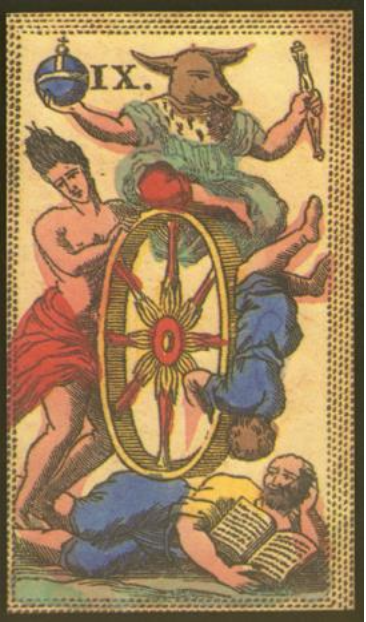

In [11]:
image_url = "https://i.ibb.co/WNGkYVnF/demo.png"
image = load_image_from_url(image_url)
image

In [13]:
from PIL import Image

def segment_image(image, levels=2):
    """8 subplot, and recursively crop from Haut, Bas, Gauche, Droite, and return all subplots and positions"""
    width, height = image.size
    sub_images = []

    def recursive_cut(x, y, w, h, level, position, parent="Main"):
        if level >= levels:
            return
    
        new_w, new_h = w // 2, h // 2
    
        # calculate 8 sub areas
        segments = [
            (x, y, new_w, new_h, "Haut-Gauche"),
            (x + new_w, y, new_w, new_h, "Haut-Droite"),
            (x, y + new_h, new_w, new_h, "Bas-Gauche"),
            (x + new_w, y + new_h, new_w, new_h, "Bas-Droite"),
            (x, y, w, new_h, "Haut"),
            (x, y + new_h, w, new_h, "Bas"),
            (x, y, new_w, h, "Gauche"),
            (x + new_w, y, new_w, h, "Droite"),
        ]
    
        for sx, sy, sw, sh, pos in segments:
            new_pos = f"{parent}_{pos}" if parent != "Main" else pos  # Add the parent's position to the name (Haut_Haut-Droite)
            sub_img = image.crop((sx, sy, sx + sw, sy + sh))
            sub_images.append((sub_img, new_pos))

            # Save the sub-image
            save_path = os.path.join(output_dir, f"{new_pos}.png")
            sub_img.save(save_path)

            
            # Only Haut, Bas, Gauche, Droite continue
            if pos in ["Haut", "Bas", "Gauche", "Droite"]:
                recursive_cut(sx, sy, sw, sh, level + 1, new_pos, parent=new_pos)
    
    # from the whole image
    recursive_cut(0, 0, width, height, 0, "Main")
    return sub_images


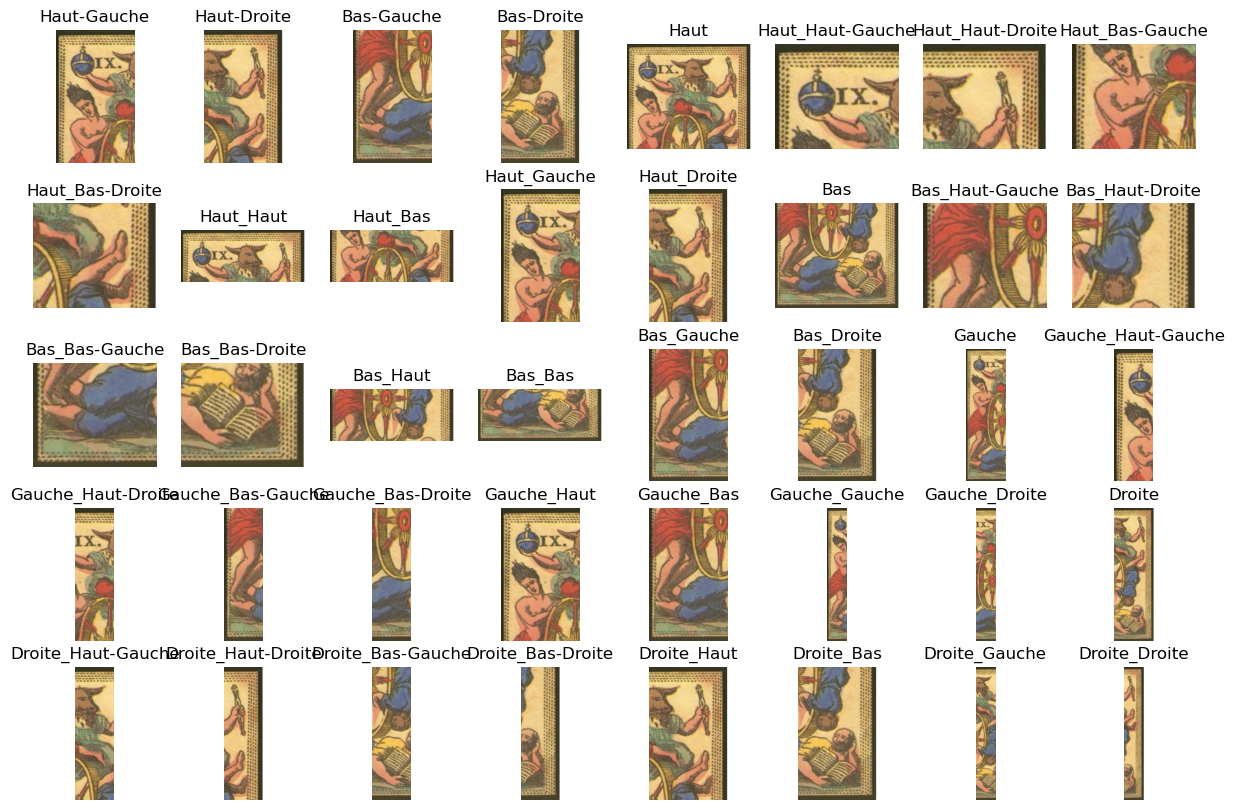

In [15]:
sub_images = segment_image(image)

# show all sub images
fig, axes = plt.subplots(5, 8, figsize=(15, 10))
axes = axes.flatten()
for ax, (img, pos) in zip(axes, sub_images):
    ax.imshow(img)
    ax.set_title(pos)
    ax.axis("off")
plt.show()

In [16]:
# Step 3: Extract CLIP
def extract_clip_features(image):
    """return Hugging Face CLIP extracting embedding"""
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        features = model.get_image_features(**inputs)
    return features.cpu().numpy().tolist()

# Step 4: call OpenAI API generate description
def generate_description(image):
    """PIL.Image -> Base64 -> OpenAI API"""
    
    # transfer PIL.Image to Base64
    buffered = BytesIO()
    image.save(buffered, format="PNG")  # keep PNG format
    base64_image = base64.b64encode(buffered.getvalue()).decode("utf-8")

    # send API request
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Please describe the content of this image"},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}}
                ],
            }
        ],
        max_tokens=100
    )

    return response.choices[0].message.content

In [17]:
results = []
    
for sub_img, position in sub_images:
    sub_vector = extract_clip_features(sub_img)
    description = generate_description(sub_img)
    description_vector = extract_clip_features(sub_img)  
    
    results.append({
        "position": position,
        "sub-image vector": sub_vector,
        "description": description,
        "description vector": description_vector
    })


print(results)

[{'position': 'Haut-Gauche', 'sub-image vector': [[-0.3966459035873413, 0.05305124819278717, -0.30635327100753784, -0.2325945794582367, 0.5231258869171143, -0.45616111159324646, 0.3137189745903015, 0.3639134466648102, -0.34304454922676086, -0.23694120347499847, -0.1960585117340088, 0.2839670181274414, 0.2789917588233948, -0.5247561931610107, -0.4037376940250397, 0.1464117169380188, 0.18741728365421295, -0.1774788796901703, 0.05693627893924713, 0.46714290976524353, -0.009190484881401062, 0.45398107171058655, 0.14367330074310303, 0.8748090267181396, 0.2333345115184784, 0.09542493522167206, 0.3591386675834656, 0.19193124771118164, -0.1271839141845703, -0.08566953241825104, 0.3389876186847687, -0.33966779708862305, 0.11781841516494751, -0.17222559452056885, 0.29985156655311584, 0.1764029562473297, -0.16598886251449585, 0.001202799379825592, 0.00863126665353775, -0.5283865928649902, 0.026003163307905197, -0.09015017747879028, 0.22621090710163116, -0.6134199500083923, 0.5451244711875916, -0.

In [18]:
with open("data.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=4)